In [1]:
pip install mne

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached matplotlib-3.10.5-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (62 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached scipy-1.16.1-cp312-cp312-macosx_10_14_x86_64.whl.metadata (61 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_10_13_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-macosx_10_13_x86_64.whl.metadata (107 kB)
  Using cached pillow-11.3.0-cp312-cp312-macosx_10_13_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 2.5 MB/s eta 0:00:0000:0100:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached matplotlib-3.10.5-cp312-cp31

In [2]:
import mne

In [14]:
eeg_raw_file=r"/Users/argus/Documents/EEGalz/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"
raw = mne.io.read_raw_eeglab (eeg_raw_file, preload = True)

In [15]:

print(raw .info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


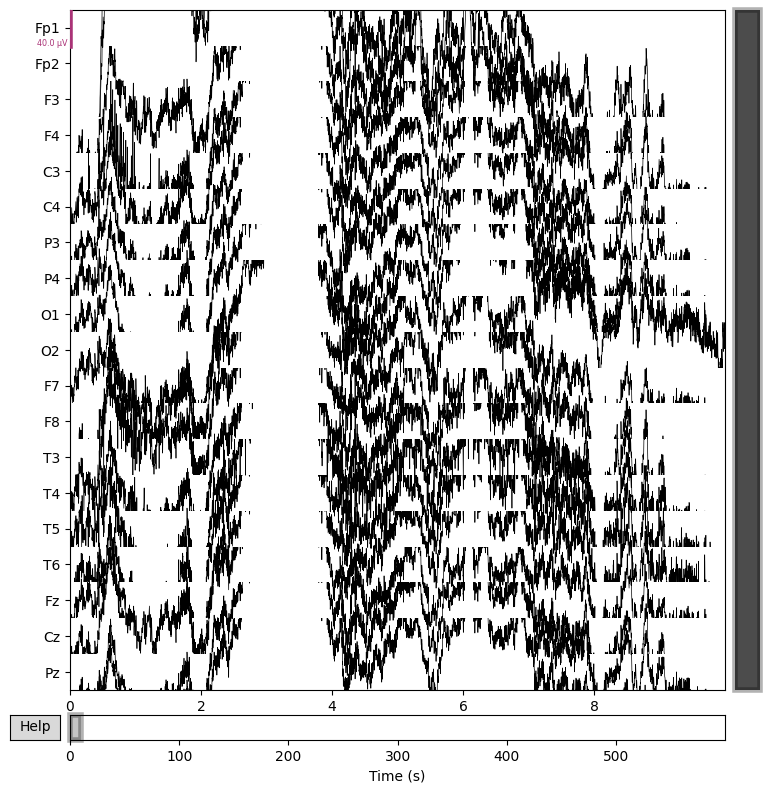

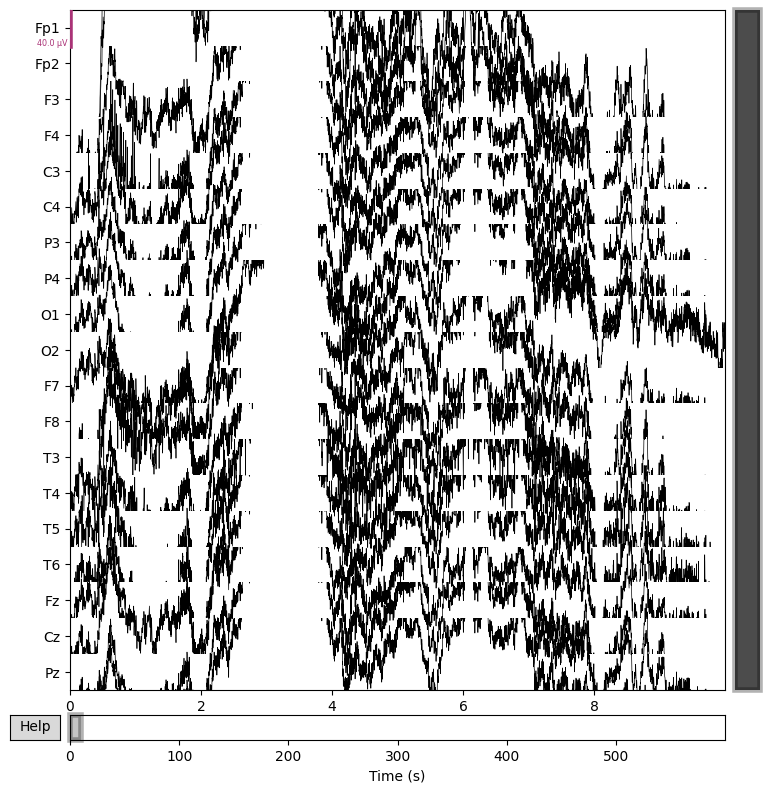

In [16]:
raw .plot()

In [17]:
# resampling - to speed up processing
raw.resample(250)

<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 149950 (599.8 s), ~21.8 MiB, data loaded>

In [18]:
# to perform feature extraction

In [20]:
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch

In [22]:
def extract_bandpowers(raw):
    data, = raw.get_data(return_times=False), raw.info["sfreq"]
    psd, freqs = psd_array_welch (data, sfreq=raw.info["sfreq"], fmin = 0.5, fmax = 45,  nfft = 1024)

    bands = {
        "delta":(0.5,4),
        "theta":(4, 8),
        "alpha":(8,13),
        "beta":(13,30),
        "gamma":(30,45)
    }

    features = {}
    for band, (low,high) in bands.items():
        idx=np.logical_and(freqs >= low, freqs <= high)
        features [f"{band}_power"] = np.mean(psd[:, idx])
    return features
    
    

In [23]:
# to build a dataset

In [32]:
subjects_info = pd.read_csv("/Users/argus/Documents/EEGalz/participants.tsv", sep="\t")
print("Available columns:", subjects_info.columns)


Available columns: Index(['participant_id', 'Gender', 'Age', 'Group', 'MMSE'], dtype='object')


In [35]:
import pandas as pd



In [37]:
import pandas as pd

# Load your participants.tsv
participants_path = "/Users/argus/Documents/EEGalz/participants.tsv"
subjects_info = pd.read_csv(participants_path, sep="\t")

# Show available columns and first few rows
print("Columns:", subjects_info.columns.tolist())
print(subjects_info.head())

Columns: ['participant_id', 'Gender', 'Age', 'Group', 'MMSE']
  participant_id Gender  Age Group  MMSE
0        sub-001      F   57     A    16
1        sub-002      F   78     A    22
2        sub-003      M   70     A    14
3        sub-004      F   67     A    20
4        sub-005      M   70     A    22


In [39]:
x = []
y = []

subjects_info = pd.read_csv("/Users/argus/Documents/EEGalz/participants.tsv", sep="\t")

for _, row in subjects_info.iterrows():
    if row["Group"] not in ["AD","CN"]:
        continue
    
    sub_id = row["participant_id"]
    label = 1 if row["diagnosis"] == "AD" else 0 #this is because AD = 1 and CN = 0
 
    file_path = f"/Users/argus/Documents/EEGalz/derivatives/{sub_id}/eeg/{sub_id}_task-eyesclosed_eeg.set"
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.resample(250)

    feats = extract_bandpowers(raw)
    X.append(feats)
    y.append(label)

X=pd.Dataframe(x)
y=np.array(y)

In [40]:
#classifier

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [44]:
print(X.shape)
print(y.shape)
print(X.head())

(0, 0)
(0,)
Empty DataFrame
Columns: []
Index: []


In [48]:
# Load participants.tsv
participants_path = "/Users/argus/Documents/EEGalz/participants.tsv"
subjects_info = pd.read_csv(participants_path, sep="\t")

# Encode categorical variables
le_gender = LabelEncoder()
le_group = LabelEncoder()

subjects_info['Gender'] = le_gender.fit_transform(subjects_info['Gender'])
subjects_info['Group'] = le_group.fit_transform(subjects_info['Group'])

# Features and target
X = subjects_info[['Gender', 'Age', 'MMSE']]
y = subjects_info['Group']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

Classification Report:
              precision    recall  f1-score   support

           A       0.67      1.00      0.80         8
           C       1.00      1.00      1.00         2
           F       1.00      0.50      0.67         8

    accuracy                           0.78        18
   macro avg       0.89      0.83      0.82        18
weighted avg       0.85      0.78      0.76        18



In [49]:
subjects_info.to_csv("subject_info.csv", index=False)

In [50]:
df = pd.read_csv("subject_info.csv")  # change filename if needed

# Features (example: Gender, Age, MMSE)
X = df[['Gender', 'Age', 'MMSE']]

# Convert categorical variables (like Gender) to numeric
X = pd.get_dummies(X, drop_first=True)

# Labels
y = df['Group']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())

(70, 3) (18, 3)
Group
0    28
1    27
2    15
Name: count, dtype: int64


In [51]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.2, random_state = 42)

clsf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clsf.fit(X_train, y_train)

y_pred = clsf.predict(X_test)

print("Accuracy", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy 0.7777777777777778
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         8

    accuracy                           0.78        18
   macro avg       0.89      0.83      0.82        18
weighted avg       0.85      0.78      0.76        18



In [53]:
# now Visualization

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


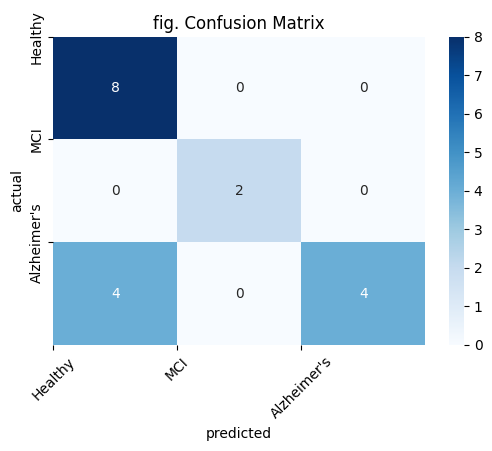

In [58]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6,4)),
sns.heatmap (cm, annot = True, fmt="d", cmap="Blues",
             xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xticks(ticks=[0, 1, 2], labels=['Healthy', 'MCI', 'Alzheimer\'s'], rotation=45)
plt.yticks(ticks=[0, 1, 2], labels=['Healthy', 'MCI', 'Alzheimer\'s'])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("fig. Confusion Matrix")
plt.show()